# Degradation functions <a class="tocSkip">

## Import MIDI

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pitch-shift" data-toc-modified-id="Pitch-shift-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pitch shift</a></span></li><li><span><a href="#Time-shift" data-toc-modified-id="Time-shift-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Time shift</a></span></li><li><span><a href="#Onset-shift" data-toc-modified-id="Onset-shift-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Onset shift</a></span></li><li><span><a href="#Offset-shift" data-toc-modified-id="Offset-shift-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Offset shift</a></span></li><li><span><a href="#Remove-note" data-toc-modified-id="Remove-note-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Remove note</a></span></li><li><span><a href="#Add-note" data-toc-modified-id="Add-note-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Add note</a></span></li><li><span><a href="#Split-note" data-toc-modified-id="Split-note-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Split note</a></span></li><li><span><a href="#Join-notes" data-toc-modified-id="Join-notes-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Join notes</a></span></li><li><span><a href="#Args-for-all-functions" data-toc-modified-id="Args-for-all-functions-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Args for all functions</a></span></li></ul></div>

In this notebook, we simply show what degradation functions are available and their parameters.

In [3]:
%pip install mido
%pip install pretty-midi

Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/5.6 MB ? eta -:--:--
     --------- ------------------------------ 1.3/5.6 MB 8.4 MB/s eta 0:00:01
     ------------------------ --------------- 3.4/5.6 MB 8.8 MB/s eta 0:00:01
     ------------------------------------- -- 5.2/5.6 MB 8.8 MB/s eta 0:00:01
     ---------------------------------------- 5.6/5.6 MB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pretty-midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592359 sha256=f53f6ea1121f8e101d455df2953a30195758141e6bb58755c43b319d410164ed
  Stored in directory: c:\users\sarag\appdata\local\pip\cache\wheels\e6\95\ac\15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty-midi
Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Audio, display

from mdtk.degradations import *
from mdtk.utils import plot_against_orig, plot_from_df, synthesize_from_note_df

First, we will construct some example data to degrade

In [2]:
# Opción 1: Usando mido
import mido
import pandas as pd

def load_midi_with_mido(midi_file_path, bpm=120):
    mid = mido.MidiFile(midi_file_path)
    
    notes = []
    
    for i, track in enumerate(mid.tracks):
        track_time = 0
        for msg in track:
            track_time += msg.time
            if msg.type == 'note_on' and msg.velocity > 0:
                # Buscar el note_off correspondiente
                temp_time = track_time
                duration = 0
                for future_msg in track[track.index(msg)+1:]:
                    temp_time += future_msg.time
                    if (future_msg.type == 'note_off' and future_msg.note == msg.note) or \
                       (future_msg.type == 'note_on' and future_msg.note == msg.note and future_msg.velocity == 0):
                        duration = temp_time - track_time
                        break
                
                # Convertir ticks a milisegundos
                ticks_per_beat = mid.ticks_per_beat
                # Asumimos 120 BPM por defecto si no se especifica
                ms_per_tick = (60000 / bpm) / ticks_per_beat
                
                notes.append({
                    'onset': track_time * ms_per_tick,
                    'pitch': msg.note,
                    'dur': duration * ms_per_tick,
                    'velocity': msg.velocity,
                    'track': i
                })
    
    return pd.DataFrame(notes)


In [3]:

# Opción 2: Usando pretty_midi (más fácil y preciso)
import pretty_midi

def load_midi_with_pretty_midi(midi_file_path):
    """
    Carga un archivo MIDI usando pretty_midi y lo convierte a DataFrame
    """
    midi_data = pretty_midi.PrettyMIDI(midi_file_path)
    
    notes = []
    
    for track_idx, instrument in enumerate(midi_data.instruments):
        for note in instrument.notes:
            notes.append({
                'onset': note.start * 1000,  # Convertir segundos a milisegundos
                'pitch': note.pitch,
                'dur': (note.end - note.start) * 1000,  # Duración en milisegundos
                'velocity': note.velocity,
                'track': track_idx
            })
    
    df = pd.DataFrame(notes)
    # Ordenar por tiempo de inicio
    df = df.sort_values('onset').reset_index(drop=True)
    
    return df



Archivo MIDI cargado exitosamente con pretty_midi
       onset  pitch         dur  velocity  track
0     0.0000     70  544.318635        80      0
1   545.4550     70  271.591135        80      0
2   818.1825     68  271.591135        80      0
3  1090.9100     66  271.591135        80      0
4  1363.6375     65  271.591135        80      0
Número de notas: 27
Duración total: 9817.05 ms


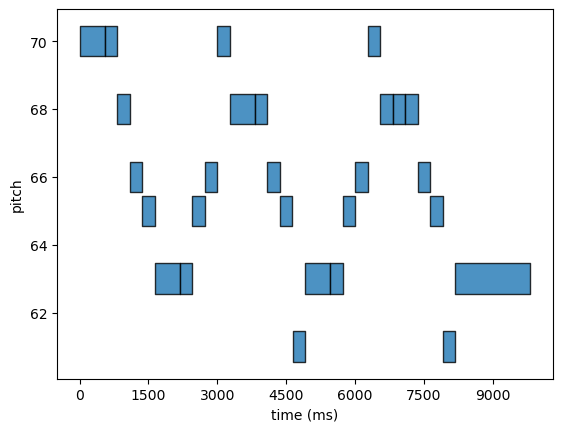

In [4]:
# Cargar tu archivo MIDI
midi_file_path = "midi/Acordai-100.mid"

# Opción recomendada: pretty_midi
try:
    excerpt = load_midi_with_pretty_midi(midi_file_path)
    print("Archivo MIDI cargado exitosamente con pretty_midi")
except:
    # Fallback a mido si pretty_midi falla
    excerpt = load_midi_with_mido(midi_file_path)
    print("Archivo MIDI cargado exitosamente con mido")

# Ahora puedes usar tu código existente:
plot_from_df(excerpt)

# Para ver la estructura de los datos cargados:
print(excerpt.head())
print(f"Número de notas: {len(excerpt)}")
print(f"Duración total: {excerpt['onset'].max() + excerpt['dur'].max():.2f} ms")

In [5]:
Audio(synthesize_from_note_df(excerpt), rate=16000)


# Mutaciones

## Pitch shift - Cambia la altura

Apply a pitch shift to one random note within the excerpt. Minimum and maximum pitches can be supplied. A distribution indicating relative probabilities of shifting the note up or down can be supplied.

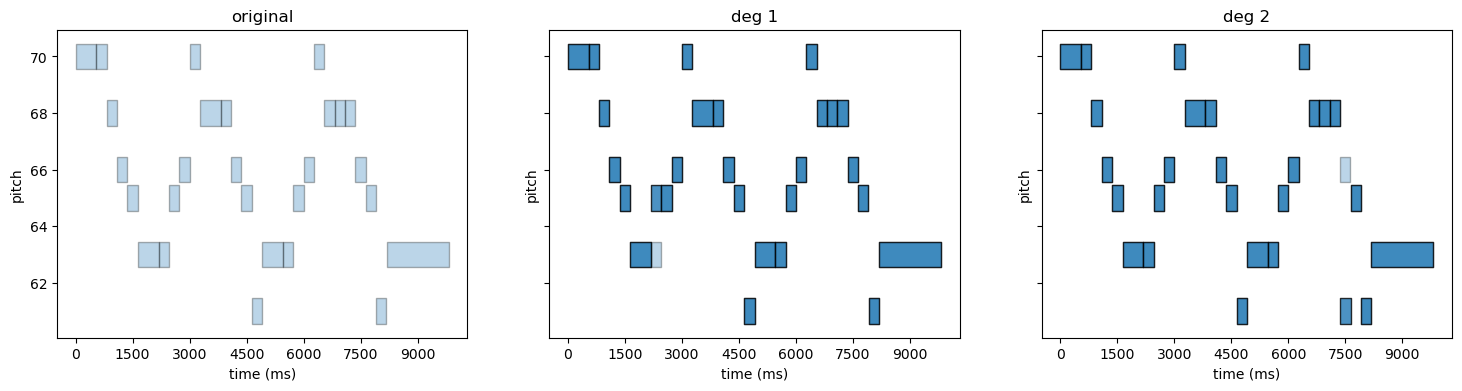

In [31]:
min_pitch = 60  # cant shift lower than 60
max_pitch = 68  # cant shift highter than 68
# distribution = [1, 0, 1, 0, 1, 0, 1]  # only shift min 2nd or maj 3rd up/down
distribution = None # no distribution, just shift randomly
align_pitch = True  # align pitch to the nearest semitone
deg_excerpt_1 = pitch_shift(
    excerpt,
    align_pitch=align_pitch,
    # min_pitch=min_pitch,
    # max_pitch=max_pitch,
    distribution=distribution,
    seed=42
)
deg_excerpt_2 = pitch_shift(
    excerpt,
    align_pitch=align_pitch,
    # min_pitch=min_pitch,
    # max_pitch=max_pitch,
    distribution=distribution,
    seed=1337
)
plot_against_orig(excerpt, [deg_excerpt_1, deg_excerpt_2])
display(Audio(synthesize_from_note_df(deg_excerpt_1), rate=16000))
display(Audio(synthesize_from_note_df(deg_excerpt_2), rate=16000))

## Time shift - Atrasar una nota (pero no cambia de duración) y las siguientes

Apply a time shift to one random note within the excerpt. Minimum and maximum shifts can be supplied. Can insist that the shifted note aligns with the onset of another in the excerpt.

In [36]:
from mdtk.mutations import *

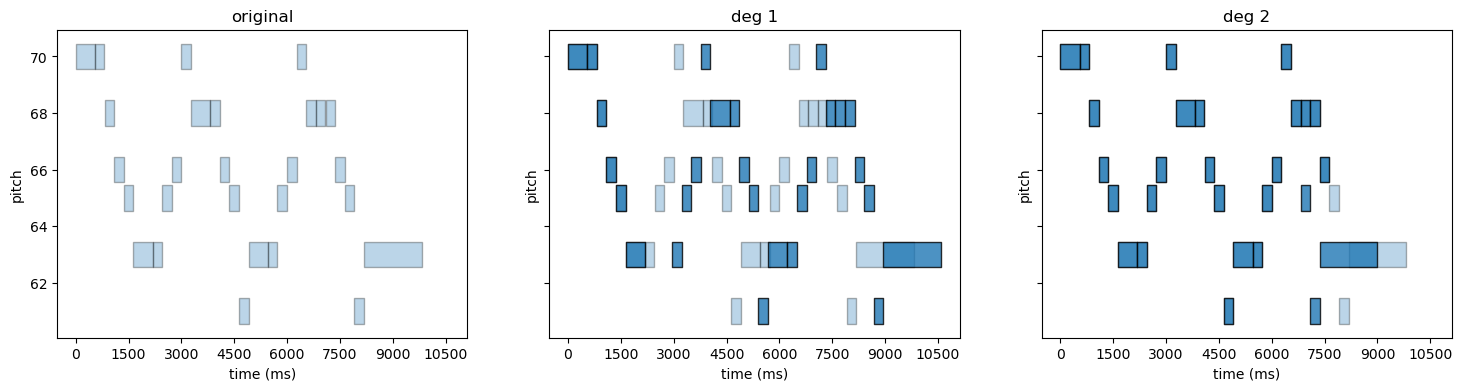

In [ ]:
min_shift = 500  # dont shift less than .5s
max_shift = 1000   # dont shift more than 1s

deg_excerpt_1 = time_shift_mutation(
    excerpt,
    min_shift=min_shift,
    max_shift=max_shift,
    align_onset=False, 
    seed=42
)
deg_excerpt_2 = time_shift_mutation(
    excerpt,
    min_shift=min_shift,
    max_shift=max_shift,
    align_onset=False, 
    seed=88
)
plot_against_orig(excerpt, [deg_excerpt_1, deg_excerpt_2])

display(Audio(synthesize_from_note_df(deg_excerpt_1), rate=16000))
display(Audio(synthesize_from_note_df(deg_excerpt_2), rate=16000))

## Onset shift - Llega tarde a una nota (y la acorta), pero las demás no se ven afectadas

Shift the onset time (time the note begins) for an existing note

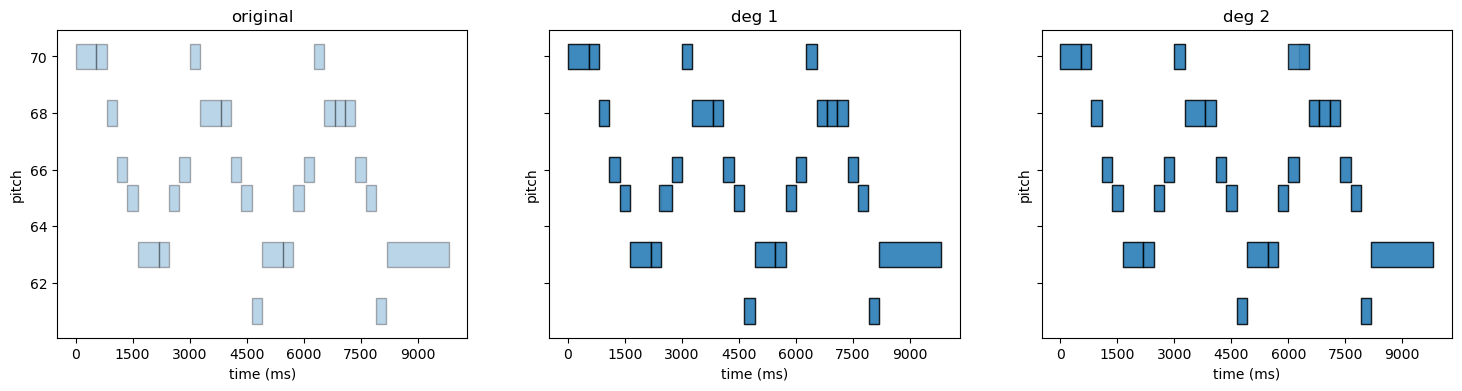

In [ ]:
min_shift = 10  # dont shift less than .01s
max_shift = 10_000   # dont shift more than 10s

deg_excerpt_1 = onset_shift(
    excerpt,
    min_shift=min_shift,
    max_shift=max_shift,
    align_onset=False,  # don't align shift with an existing note
    seed=1337
)
deg_excerpt_2 = onset_shift(
    excerpt,
    min_shift=min_shift,
    max_shift=max_shift,
    align_onset=True,  # align shift with an existing note
    seed=1337
)
plot_against_orig(excerpt, [deg_excerpt_1, deg_excerpt_2])
display(Audio(synthesize_from_note_df(deg_excerpt_1), rate=16000))
display(Audio(synthesize_from_note_df(deg_excerpt_2), rate=16000))

In [17]:
?onset_shift

Signature:
onset_shift(
    excerpt,
    min_shift=100,
    max_shift=inf,
    min_duration=50,
    max_duration=inf,
    align_onset=False,
    align_dur=False,
    tries=10,
)
Docstring:
Shift the onset time of one note from the given excerpt.

Parameters
----------
excerpt : df.DataFrame
    An excerpt from a piece of music.

min_shift : int
    The minimum amount by which the onset time will be changed.

max_shift : int
    The maximum amount by which the onset time will be changed.

min_duration : int
    The minimum duration for the resulting note.

max_duration : int
    The maximum duration for the resulting note.
    (The offset time will never go beyond the current last offset
    in the excerpt.)

align_onset : boolean
    True to force the shifted onset to lie on an existing onset.

align_dur : boolean
    True to force the resulting duration to be equal to an existing
    duration.

seed : int
    A seed to be supplied to np.random.seed(). None leaves numpy's
    random st

## Offset shift - Alarga la duración de una nota
Podría servir para ver cómo afecta a las pruebas, ya que en la guitarra se puede producir un efecto similar si se tocan las cuerdas al aire y no se apagan, especialmente las más graves.

Shift the offset time (time the note ends) for an existing note

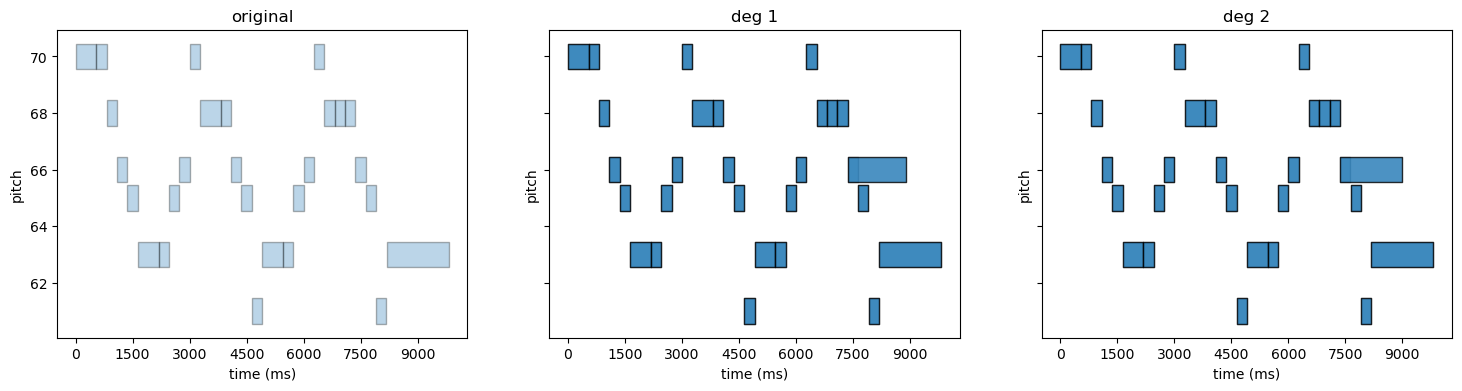

In [8]:
min_shift = 10  # dont shift less than .01s
max_shift = 10_000   # dont shift more than 10s

deg_excerpt_1 = offset_shift(
    excerpt,
    min_shift=min_shift,
    max_shift=max_shift,
    align_dur=False,  # don't force duration to match an existing note
    seed=1337
)
deg_excerpt_2 = offset_shift(
    excerpt,
    min_shift=min_shift,
    max_shift=max_shift,
    align_dur=True,  # force duration to match an existing note
    seed=1337
)
plot_against_orig(excerpt, [deg_excerpt_1, deg_excerpt_2])

display(Audio(synthesize_from_note_df(deg_excerpt_1), rate=16000))
display(Audio(synthesize_from_note_df(deg_excerpt_2), rate=16000))

## Remove note - Elimina una nota, pero no afecta en nada a las demás

Remove a note from the excerpt

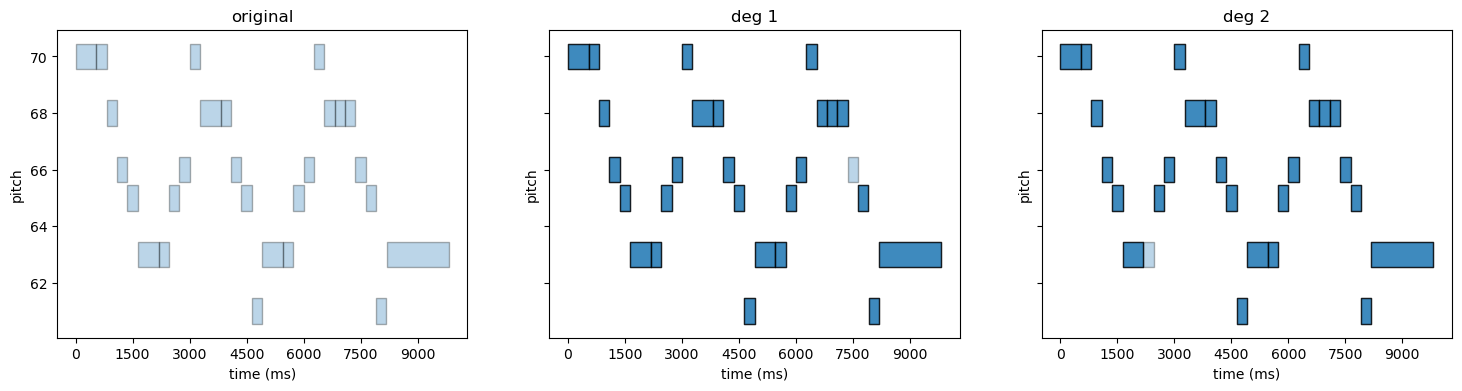

In [48]:
deg_excerpt_1 = remove_note(
    excerpt,
    seed=1337,
)
deg_excerpt_2 = remove_note(
    excerpt,
    seed=42,
)
plot_against_orig(excerpt, [deg_excerpt_1, deg_excerpt_2])
display(Audio(synthesize_from_note_df(deg_excerpt_1), rate=16000))
display(Audio(synthesize_from_note_df(deg_excerpt_2), rate=16000))

## Add note - Añade una nota que no estaba, pero no afecta al ritmo

Add a completely new note to the excerpt with configurable min and max pitches, durations, and velocities. The added note can also be aligned in pitch, time, and/or velocity with an existing note within the excerpt. By default, any added note will have velocity 100.

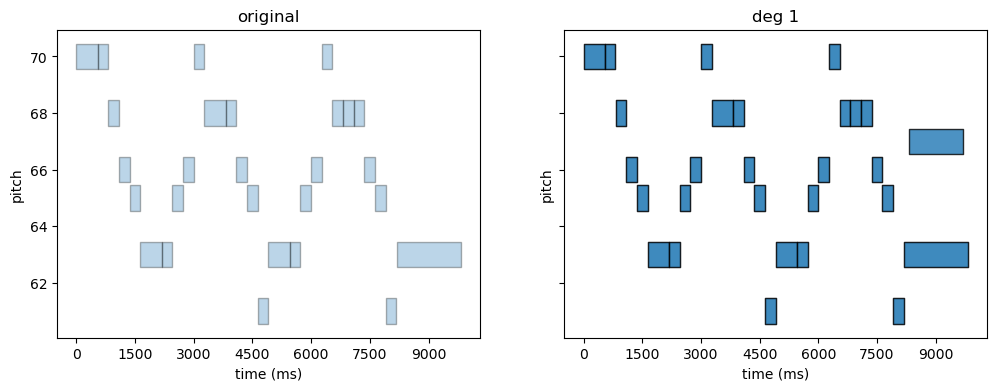

In [58]:
min_dur = 50
max_dur = 5_000
min_velocity = 60
max_velocity = 100

deg_excerpt_1 = add_note(
    excerpt,
    min_pitch=min_pitch,
    max_pitch=max_pitch,
    min_duration=min_dur,
    max_duration=max_dur,
    min_velocity=min_velocity,
    max_velocity=max_velocity,
    align_pitch=False,
    align_time=False,
    align_velocity=False,
    seed=42
)
# deg_excerpt_2 = add_note(
#     excerpt,
#     min_pitch=min_pitch,
#     max_pitch=max_pitch,
#     min_duration=min_dur,
#     max_duration=max_dur,
#     min_velocity=min_velocity,
#     max_velocity=max_velocity,
#     align_pitch=True,
#     align_time=True,
#     align_velocity=True,
#     seed=42
# )
plot_against_orig(excerpt, [deg_excerpt_1])

display(Audio(synthesize_from_note_df(deg_excerpt_1), rate=16000))
# display(Audio(synthesize_from_note_df(deg_excerpt_2), rate=16000))

## Split note - La duración de una nota se divide en varias partes, pero sigue teniendo la misma duración total. Es como alargar una nota a través de varios ataques.

Split an existing note in the excerpt a given number of times.

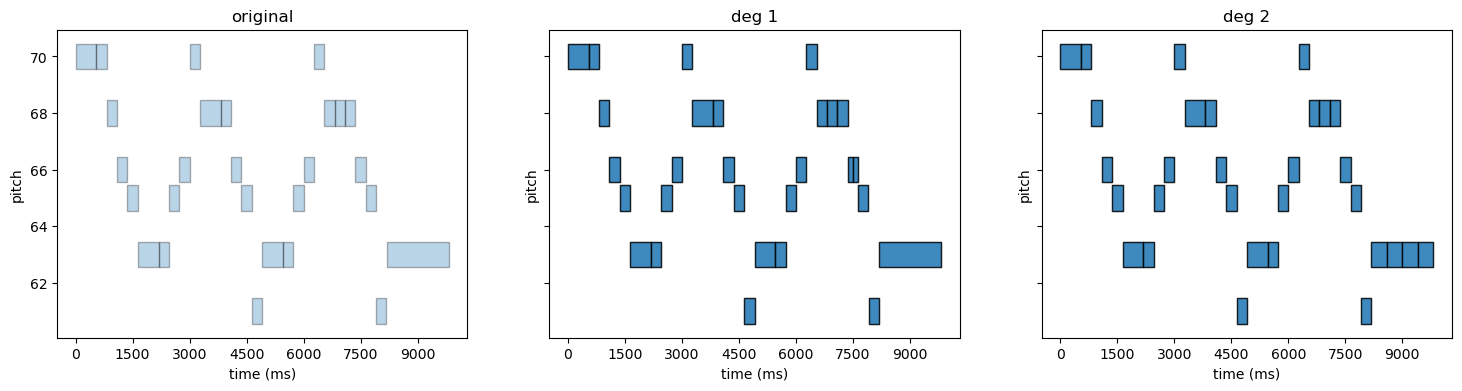

In [54]:
min_duration = 100  # dont create notes less than .1s

deg_excerpt_1 = split_note(
    excerpt,
    min_duration=min_duration,
    num_splits=1,
    seed=1337
)
deg_excerpt_2 = split_note(
    excerpt,
    min_duration=min_duration,
    num_splits=3,
    seed=1337
)
plot_against_orig(excerpt, [deg_excerpt_1, deg_excerpt_2])
display(Audio(synthesize_from_note_df(deg_excerpt_1), rate=16000))
display(Audio(synthesize_from_note_df(deg_excerpt_2), rate=16000))

## Join notes - Ligar varias notas

Join a given number of existing notes together.

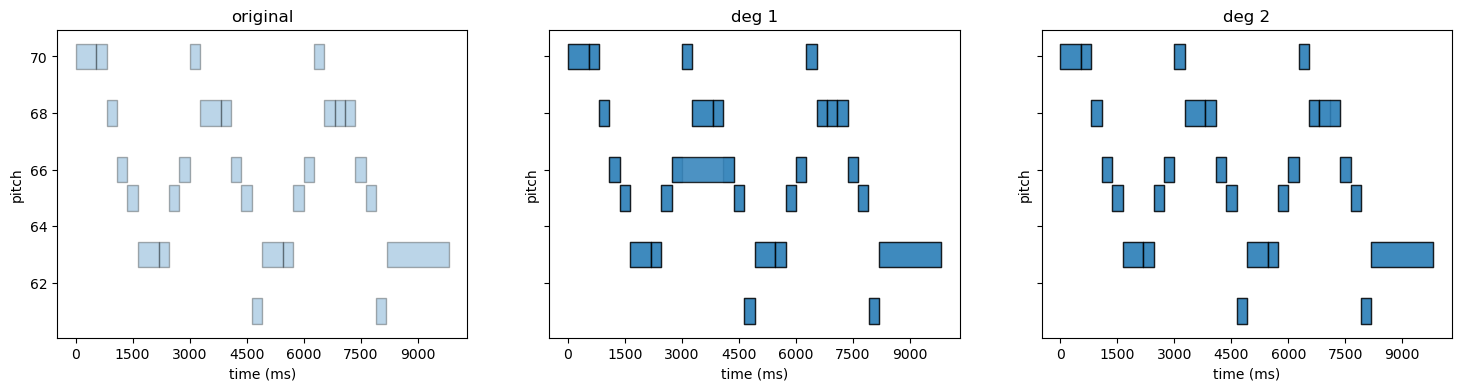

In [56]:
max_gap = 2000  # max gap between notes to join is 2s

deg_excerpt_1 = join_notes(
    excerpt,
    max_gap=max_gap,
    max_notes=2,
    seed=1337
)
deg_excerpt_2 = join_notes(
    excerpt,
    max_gap=max_gap,
    max_notes=20,
    seed=0
)
plot_against_orig(excerpt, [deg_excerpt_1, deg_excerpt_2])
display(Audio(synthesize_from_note_df(deg_excerpt_1), rate=16000))
display(Audio(synthesize_from_note_df(deg_excerpt_2), rate=16000))

## Args for all functions

All functions have a `seed` and `tries` arguments. 

The `seed` argument ensures the outcome is deterministic - the outcome is reproduced if the same seed is supplied (provided the same input is supplied!). 

The `tries` argument is there to handle difficult settings of the arguments. In these cases, the function will try `tries` attempts, and return none if no result is found.

For example, trying to split a note in our example into 10 parts of at minimum size 1s is never possible:

In [ ]:
split_note(
    excerpt,
    min_duration=1000,
    num_splits=10,
    seed=1337
)

In some cases, a degradation may sometimes be possible, but not always. The user can increase the number of attempts using `tries`, to reduce the probability of failure.

In [ ]:
new_excerpt = pd.DataFrame({
    "onset": [0, 500],
    "track": [0, 0],
    "pitch": [60, 61],
    "dur": [1000, 1000],
    "velocity": [100, 100],
})

In [ ]:
pitch_shift(
    new_excerpt,
    min_pitch=60,
    max_pitch=62,
    seed=0,
    tries=2,
)

In [ ]:
pitch_shift(
    new_excerpt,
    min_pitch=60,
    max_pitch=62,
    seed=0,
    tries=3,
)

onset  track  pitch   dur  velocity
0      0      0     60  1000       100
1    500      0     62  1000       100